In [ ]:
import torch
!pip install pytorch-lightning
device = torch.device('cuda:0')
assert isinstance(device, torch.device)
print('Running on: {}'.format(device))

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/DatasetLow.zip' #-d '/content/drive/My Drive/'

In [ ]:
!pip install soundfile
import soundfile as sf
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from torch.utils.data import DataLoader
import IPython.display as ipd
import torch
from torch import nn
from scipy import signal
from tqdm import tqdm
import glob
import re
import torch.nn.functional as F
%matplotlib inline

In [ ]:
data_root = '/content/DatasetLow'
labels = ['female_australia',
          'female_england',
          'female_us',
          'female_indian',
          'female_canada',
          'male_australia',
          'male_england',
          'male_us',
          'male_indian',
          'male_canada',]

for i in labels:
  lst = glob.glob('/content/DatasetLow/' + i + '/*.mp3')
  print(lst)
  for file in tqdm(lst):
    os.system(f"""ffmpeg -i {file} -acodec pcm_u8 -ar 22050 {file[:-4]}.wav""")
    if re.search('.+.mp3', file):
      os.remove(file)


train_list = os.listdir(data_root)


In [ ]:
  audio1 = os.path.join(data_root,train_list[9])
  z = os.listdir(audio1)
  audio2 = os.path.join(audio1,z[1])

In [ ]:
sig, sr = sf.read(audio2)
ipd.Audio(sig,rate=sr)

In [ ]:
def any_sound(data_root,which_label,which_image):
  audio1 = os.path.join(data_root,train_list[which_label])
  z = os.listdir(audio1)
  audio2 = os.path.join(audio1,z[which_image])
  sig, sr = sf.read(audio2)
  fft = np.fft.fft(sig)
  magnitude = np.abs(fft)
  frequency = np.linspace(0,sr, len(magnitude))
  left_frequency = frequency[:int(len(frequency)/2)]
  left_magnitude = magnitude[:int(len(frequency)/2)]
  plt.plot(left_frequency,left_magnitude)
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.show()
  librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(sig, n_fft=512, hop_length=128)), ref=np.max), y_axis='linear', hop_length=256, sr=sr)
  plt.colorbar(format='%+2.0f dB')
  return ipd.Audio(sig, rate= sr)

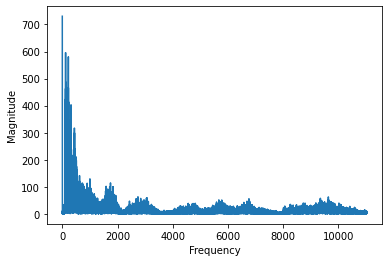

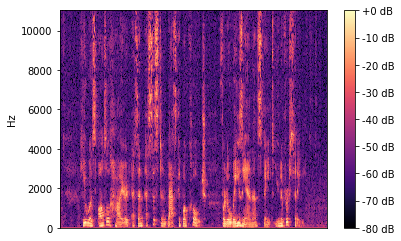

In [ ]:
any_sound(data_root, 8, 11)

In [ ]:
list = []
for label in labels:
    file_names = os.listdir(os.path.join(data_root, label))
    for file in file_names:
        full_path = os.path.join(data_root, label, file)
        list.append(full_path)
m = len(list)
list.sort()
np.random.seed(230)
perm = np.random.shuffle(list)
train_end = int(.8 * m)
validate_end = int(.1 * m) + train_end
train = list[:train_end]
val = list[train_end:validate_end]
test = list[validate_end:]
len(train),len(test),len(val)

(4000, 500, 500)

In [ ]:
def zero_padding(sig, output_length):
    diff = output_length - sig.shape[0]
    if diff < 0:
        return sig
    else:
        pad_l = np.zeros(diff//2,)
        pad_r = np.zeros(diff - pad_l.shape[0],)
        new_sig = np.concatenate([pad_l.astype(np.float32),sig, pad_r.astype(np.float32)]) 
        return new_sig

In [ ]:
def mfcc(sig, output_length = 12*22050):
  if sig.shape[0]< output_length:
        sig = zero_padding(sig, output_length)
  features = librosa.feature.mfcc(sig, sr=8000, hop_length=120, n_fft=512, n_mels=128, n_mfcc=13)
  return features

In [ ]:
class_to_idx = dict(zip(labels,range(len(labels))))

In [ ]:
train_x=[]
train_y=[]
for i in tqdm(train):
  class_name = i.split('/')[-2]
  sig, _ = sf.read(i)
  features = mfcc(sig)
  train_x.append(features)
  train_y.append(class_to_idx[class_name])

In [ ]:

test_x=[]
test_y=[]
val_x=[]
val_y=[]


for i in tqdm(test):
  class_name = i.split('/')[-2]
  sig, sr = sf.read(i)
  features = mfcc(sig)
  test_x.append(features)
  test_y.append(class_to_idx[class_name])
for i in tqdm(val):
  class_name = i.split('/')[-2]
  sig, sr = sf.read(i)
  features = mfcc(sig)
  val_x.append(features)
  val_y.append(class_to_idx[class_name])

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_x, dtype=torch.float32).unsqueeze(1), torch.tensor(train_y))

In [ ]:
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_x, dtype=torch.float32).unsqueeze(1), torch.tensor(val_y))

In [ ]:
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_x, dtype=torch.float32).unsqueeze(1), torch.tensor(test_y))

In [ ]:
class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()

        self.core = torch.nn.Sequential(
            nn.Conv2d(1,32,(3,5)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,32,(3,5)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,(3,5)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)))
        self.fc = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.core(x)
        x = x.view(x.shape[0],-1)
        print(x.shape)
        return self.fc(x)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
class VoiceClassification(pl.LightningModule):

    def __init__(self, tr_dataset, val_dataset, test_dataset, batch_size=16):
        super(VoiceClassification, self).__init__()

        self.train_dataset = tr_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset

        self.batch_size = batch_size
        
        self.net = BasicModel()
        
        
    def forward(self, x):
        return self.net(x)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        correct=logits.argmax(dim=1).eq(y).sum().item()
        total=len(y)
        loss = F.cross_entropy(logits, y)

        logs = {'train_loss': loss}
        batch_dictionary={
            "loss": loss,
            
            "log": logs,

            "correct": correct,
            "total": total
        }

        return batch_dictionary
    def training_epoch_end(self,outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        correct=sum([x["correct"] for  x in outputs])
        total=sum([x["total"] for  x in outputs])

        tensorboard_logs = {'loss': avg_loss,"Accuracy": correct/total}

        epoch_dictionary={
            'loss': avg_loss,
            'log': tensorboard_logs}

        return epoch_dictionary

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, 1)
        val_acc = ((preds == y).sum())*1.0/x.shape[0]
        return {'val_loss': loss, 'val_acc': val_acc}


    def validation_epoch_end(self, outputs):
        val_loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_acc_mean = 0
        for output in outputs:
            val_acc_mean += output['val_acc']
        val_acc_mean /= len(outputs)
        tqdm_dict = {'val_acc': val_acc_mean.item()}
        tensorboard_logs = {'val_loss': val_loss_mean, 'val_acc': val_acc_mean}
        return {'val_loss': val_loss_mean, 'log': tensorboard_logs, 'progress_bar': tqdm_dict}

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        preds = torch.argmax(self.forward(x), 1)
        acc_batch = ((preds == y).sum())*1.0/x.shape[0]
        return {'acc': acc_batch}
    
    def test_epoch_end(self, outputs):
        test_acc_mean = 0
        for output in outputs:
            test_acc_mean += output['acc']

        test_acc_mean /= len(outputs)
        tqdm_dict = {'test_acc': test_acc_mean.item()}

        results = {
            'progress_bar': tqdm_dict,
            'log': {'test_acc': test_acc_mean.item()}
        }
        return results

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        return optimizer
    

early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.0,
   patience=20,
   verbose=False,
   mode='min'
)


checkpoint_callback = ModelCheckpoint(
    filepath=os.getcwd()+'/content//Voice_Classifier/',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix='model_3'
)
model = VoiceClassification(tr_dataset=train_dataset, test_dataset=test_dataset, val_dataset=val_dataset, batch_size=128)

In [ ]:

trainer = pl.Trainer(early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback,  max_epochs=50)

trainer.fit(model)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/